<sub>Mario Stanke, University of Greifswald, Germany</sub>
# Linear Regression Example
<sup>(a very special case of a neural network)</sup>

## Bike Sharing Demand
 - data set of *bike rental counts* in a Washington, D.C., bikeshare program 
 - much simplified data table with only
    - ```temp``` - temperature in Celsius
    - ```count``` - number of total rentals
    for individual hours during daytime and summer
    - other features like humidity, weekday, holiday and time of day ignored
 - **task**: predict bike rental demand (count of bikes) based on temperature
 - data source: [kaggle](https://www.kaggle.com/c/bike-sharing-demand)

Import libraries
 - [Pandas](https://pandas.pydata.org) for reading input tables from a file to a *data frame*.
 - [Matplotlib](https://matplotlib.org) for making plots.
 - [TensorFlow](https://www.tensorflow.org) to compute gradients and general machine learning.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
print(tf.__version__) # Is this really at least version 2? Make sure when using own computer.

2.0.0-rc0


In [3]:
# load the training data from the table file to a pandas data frame
df = pd.read_csv("bikes-summerdays.tbl", sep='\s+')
print(df.head()) # show first lines as examples

# convert count data to floats as regression target
df['count'] = df['count'].astype(float) 
print(df.dtypes)

m, n_cols = df.shape # training set size and number of columns 
print("m = ", m, "\tn_cols = ", n_cols)

# compute average of hourly bike rental counts
meancount = np.mean(df['count'])
print ("mean bike count = ", meancount)

    temp  count
0  13.12    173
1  13.12     75
2  13.12     89
3  13.94     95
4  14.76    110
temp     float64
count    float64
dtype: object
m =  1482 	n_cols =  2
mean bike count =  311.0


### Make a first explorative plot

<IPython.core.display.Javascript object>


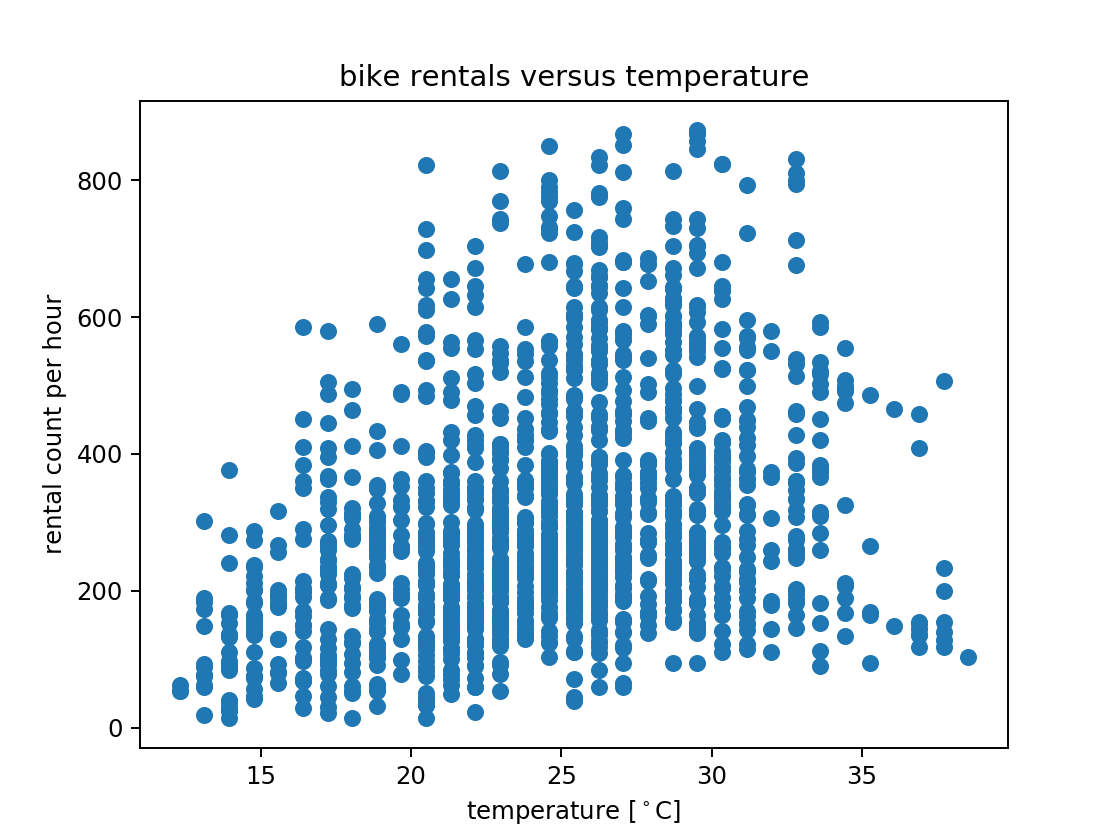

In [4]:
# the next line is optional but makes the plot interactive
%matplotlib notebook

def scatterplot_rentals():
    ''' Plot the bike rental counts versus the temperature.'''
    _, ax = plt.subplots()
    ax.scatter(df["temp"], df["count"])
    plt.title("bike rentals versus temperature")
    plt.xlabel('temperature [' + r'$^\circ$' + 'C]')
    plt.ylabel('rental count per hour');
    return ax

ax = scatterplot_rentals()

In [5]:
# print summary statistics 
df.describe()

,temp,count
count,1482.000000,1482.000000
mean,24.612173,311.000000
std,4.979788,174.792339
min,12.300000,14.000000
25%,21.320000,184.000000
50%,24.600000,272.000000
75%,27.880000,398.750000
max,38.540000,873.000000


## Linear Regression

Input variables $x_1,\ldots, x_n$ (<span style="color:red">features</span>). Here: $n=1$ and $x_1=$ temperature.

Real valued output variable $y$ (aka <span style="color:red">response</span> variable). Here, $y=$ bike count.

### Hypothesis function
Let ${\bf x}=(x_1,\ldots, x_n)^T$ be an input vector and $\pmb{\theta}=(\theta_0,\theta_1,\ldots, \theta_n)^T$ be a vector of unknown coefficients (<span style="color:red">parameters</span>). The function

$$h_{\pmb{\theta}}({\bf x}) := \theta_0 + \theta_1 x_1 + \cdots \theta_n x_n$$

is called the <span style="color:red">hypothesis</span>.

**Aim**: Find parameters $\pmb{\theta}$ such that, roughly speaking,
$h_{\pmb{\theta}}({\bf x}) \approx y$
for most *examples* $({\bf x}, y)$ from a data set or data distribution.

### Data set
Let $m$ be the number of training examples (pairs of input/output), 

$${\bf X} := \begin{pmatrix}
1 & x^{(1)}_1 & x^{(1)}_2 & \cdots & x^{(1)}_n\\
\vdots & \vdots & \vdots & &\vdots\\ 
1 & x^{(m)}_1 & x^{(m)}_2 & \cdots & x^{(m)}_n\\
\end{pmatrix} = \left(x^{(i)}_j\right)_{\tiny\begin{array}{l}1\le i\le m\\ 0\le j \le n\end{array}
},$$

be the *data matrix*, where $x^{(i)}_j$ is the value of the $j$-th feature of the $i$-th example, $x_0^{(j)}:=1$, and 

$${\bf y} = \begin{pmatrix}y_1\\\vdots\\y_m\end{pmatrix}$$

be the vector of responses.


### Mean squared error function
Define the *mean squared error* function

$$\text{MSE}(\pmb{\theta}) = \frac{1}{m} ({\bf X} \pmb{\theta} - {\bf y})^2  
= \frac{1}{m} \sum_{i=1}^m \left(h_{\pmb{\theta}}({\bf x}^{(i)}) - y_i\right)^2, \qquad \qquad (1)$$

where the square is meant to be applied componentwise to a vector. In machine learning (ML), $\text{MSE}$ is called a
<span style="color:red">loss function</span>. It is our target to be minimized:

$$ \text{MSE}(\pmb{\theta}) \to \min$$

## Create Data Matrix $X$ and response vector $y$

In [6]:
# extract response vector
y_train = np.array(df['count']) 

# extract feature columns
n = n_cols - 1 # number of features
temps = np.array(df.loc[:, df.columns != 'count']) # matrix of all other columns (here only one col)

# make data matrix X
X_train = np.ones((m, n+1)) # initialize with all ones
# overwrite all but the zero-th column with features
X_train[:,1:n+1] = temps / 10 - 2.5 # normalize temperatures so they are roughly in [-1,1] 

# print first 5 examples
print("X_train:\n ", X_train[0:5,], "\ny_train :" , y_train[0:5])

X_train:
  [[ 1.    -1.188]
 [ 1.    -1.188]
 [ 1.    -1.188]
 [ 1.    -1.106]
 [ 1.    -1.024]] 
y_train : [173.  75.  89.  95. 110.]


## Define Loss Function

In [7]:
# mean squared error loss function
def MSE(theta):
    """
        Mean squared error function for linear regression
        theta: numpy array of parameters, the first dimension must match the number of cols of X
               If theta is 2-dimensional, the output is 1-dim with one entry per col of theta.
    """
    if len(theta.shape) == 1: # theta is 1-dimensional
        theta = tf.reshape(theta, (-1, 1)) # make it a matrix with one column
    # now theta is a matrix in any case
    yhat = tf.linalg.matmul(X_train, theta) # vector of predicted rental counts
    d = (yhat - y_train.reshape((-1, 1)))**2 # square the residuals ('errors')
    E = tf.reduce_sum(d, axis=0) / m
    return E

In [8]:
# two tests of calls to error function
print("single point:", MSE(np.array([1., 2.])))
print("two points: ", MSE(np.array([[1., 3.], [2., 4.]])))

single point: tf.Tensor([126566.30681717], shape=(1,), dtype=float64)
two points:  tf.Tensor([126566.30681717 125266.24137933], shape=(2,), dtype=float64)


<IPython.core.display.Javascript object>


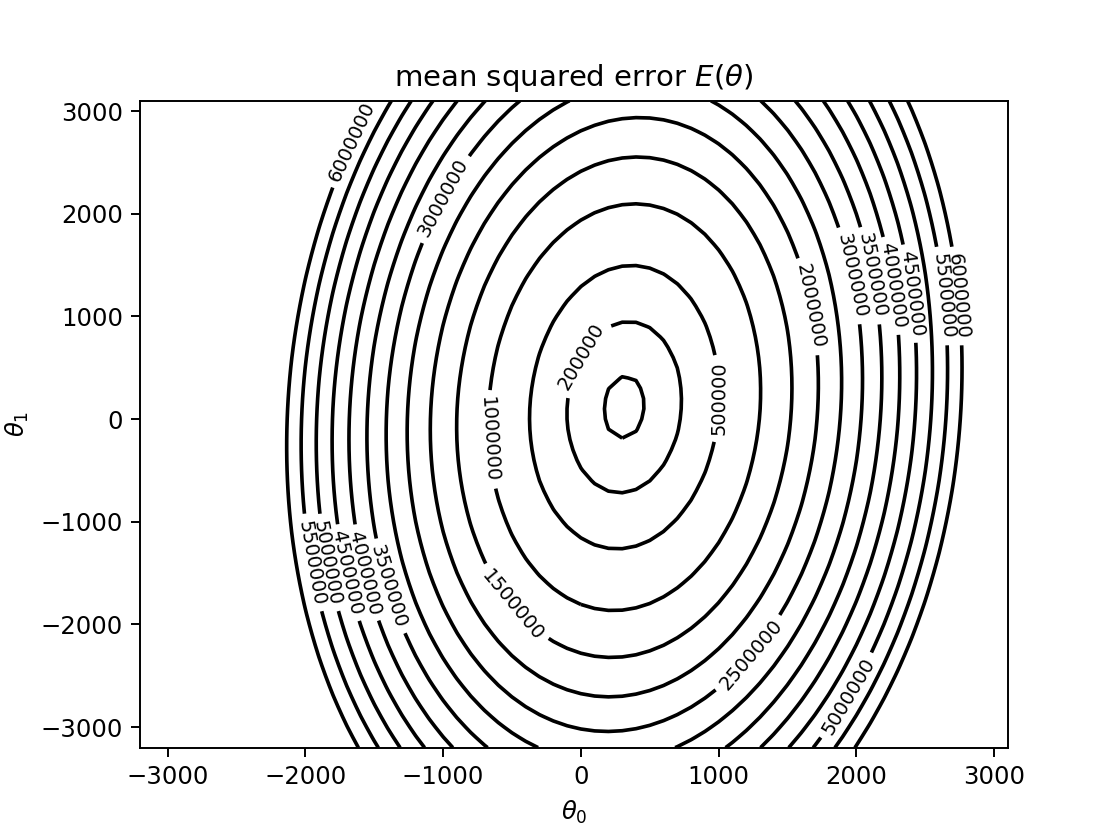

In [9]:
# this is for lecture purposes only and NEED NOT BE READ
def contourPlot():
    ''' Plot the error landscape'''
    # compute error for the grid of all combinations of theta0 and theta1 values
    theta0 = theta1 = np.arange(-3200., 3200., 100) # grid axis ranges
    xv, yv = np.meshgrid(theta0, theta1) # x and y values of all grid points
    Theta = np.array([xv, yv]).reshape(2, -1) # 2 rows, one col per grid point

    # compute error for all grid points
    z = MSE(Theta).numpy()
    z = z.reshape((theta0.size, -1)) # make this a matrix again as required by contour

    ## make contour plot
    _, axC = plt.subplots()
    # heights to draw contour lines for
    h = [50000, 200000] + list(range(500000, 6000001, 500000))
    contours = axC.contour(theta0, theta1, z, levels=h, colors='black')
    axC.clabel(contours, inline=True, fontsize=8, fmt='%i') # labels on lines
    plt.title("mean squared error " + r'$E(\theta)$');
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$');
    return axC

axC = contourPlot() 

## Gradient and Gradient Descent
Gradient descent is a simple optimization algorithm, where the parameters are iteratively updated, by moving each time a (small) step into the direction of the steepest descend of the target function to be minimized:
$$ \pmb{\theta} \leftarrow \pmb{\theta} - \alpha \cdot\nabla \;\text{MSE}(\pmb{\theta})
\qquad \qquad \qquad (2)$$

Here, 
$$\nabla\; \text{MSE}(\pmb{\theta}) = \left(\frac{\partial\, \text{MSE}(\pmb{\theta})}{\partial\, \theta_0} , 
\ldots, \frac{\partial\, \text{MSE}(\pmb{\theta})}{\partial\, \theta_n}\right)^T$$ 
is the *gradient* of the mean squared error function in the point $\pmb{\theta}$ and $\alpha$ is called the *learning rate*. 

The rationale (not guaranteed) is that $\pmb{\theta}$ may converge to a *local* optimum. In ML practice, usually a little more sophisticated methods are used, but they also require iterative updates based on the gradient.

## Solution 1: low-level
Let us first (but never later) do it with a simple self-implemented gradient descent.

In [10]:
def gradient_descent(theta_init, learning_rate):
    ''' Simple gradient descent algorithm.'''
    N = 100 # number of update steps
    alpha = learning_rate; # learning rate
    
    # create variable for model parameters (weights) and initialize it
    theta = tf.Variable(theta_init, dtype=tf.float64, name = "weights", trainable = True)
    
    # variable to monitor progress
    err = np.zeros(N + 1) # error after each update step
    Theta = np.zeros((2, N + 1)) # sequence of parameters after each step
    
    # simple gradient descent loop
    for i in range(N+1):        
        with tf.GradientTape() as tape: # to be explained and practiced later
            E = MSE(theta)
        
        Theta[:, i] = theta.numpy()
        err[i] = E.numpy().squeeze()
        if i < N+1:
            grad = tape.gradient(E, theta) # let tf compute the derivate of E wrt to theta
            theta.assign(theta - alpha * grad) # core update step from formula (2)
            if (i%10 == 0): # output some algorithm progress
                print ("error after ", i, " iterations: ", err[i], " gradient= ", grad.numpy())
    return [Theta, err]

## Visualization of optimization progress

In [11]:
def plot_progress(Theta, err, col):
    ''' Plot error over time'''
    plt.subplots()
    plt.plot(np.log(err), 'o-', color=col, linewidth=.2, markersize=3, mfc='none')
    plt.title("Log training error by iteration of gradient descent")
    plt.xlabel('iteration '+r'$i$')
    plt.ylabel(r'$ln \;E(\theta^{(i)})$');

    # enter parameter trajectory to above contour plot
    axC = contourPlot()
    plt.plot(Theta[0, 0], Theta[1, 0], 'o', color='green', mfc='none') # mark starting point with circle
    ymin, ymax = axC.get_ylim()
    xmin, xmax = axC.get_xlim()
    for i in range(1, Theta.shape[1]):
        if (np.abs(Theta[0, i] - Theta[0, i-1]) + np.abs(Theta[1, i] - Theta[1, i-1]) > 1e-6):
            # above condition avoids arrows with a length of 0 pixels
            plt.arrow(Theta[0, i-1], Theta[1, i-1], Theta[0, i] - Theta[0, i-1], Theta[1, i] - Theta[1, i-1],
                      color=col, width=5, head_length=60, head_width=80, overhang=.9, length_includes_head=True)

### A successful run of gradient descent

error after  0  iterations:  4562314.689608637  gradient=  [3145.30364372 1307.64634278]
error after  10  iterations:  182621.03210795502  gradient=  [ 23.1143384 391.4135199]
error after  20  iterations:  38312.487842296905  gradient=  [  5.39240034 104.59867878]
error after  30  iterations:  28014.993172670802  gradient=  [ 1.43972439 27.94150623]
error after  40  iterations:  27280.17886072767  gradient=  [0.38459317 7.46402063]
error after  50  iterations:  27227.743575207885  gradient=  [0.10273646 1.99386544]
error after  60  iterations:  27224.001869143027  gradient=  [0.02744401 0.53262171]
error after  70  iterations:  27223.73486641506  gradient=  [0.00733112 0.14227935]
error after  80  iterations:  27223.715813486917  gradient=  [0.00195836 0.03800711]
error after  90  iterations:  27223.71445389755  gradient=  [0.00052314 0.01015285]
error after  100  iterations:  27223.714356879223  gradient=  [0.00013975 0.00271213]
theta after optimization:  [315.48111677 115.54233945]


<IPython.core.display.Javascript object>


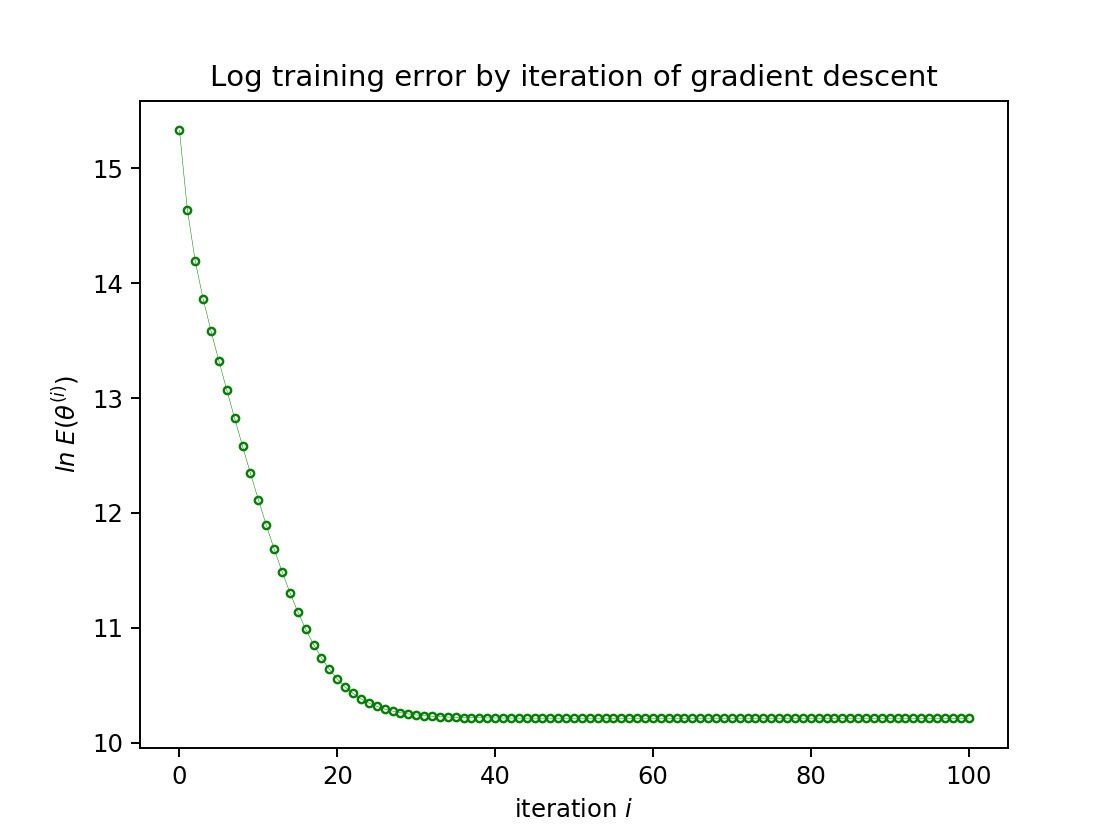

<IPython.core.display.Javascript object>


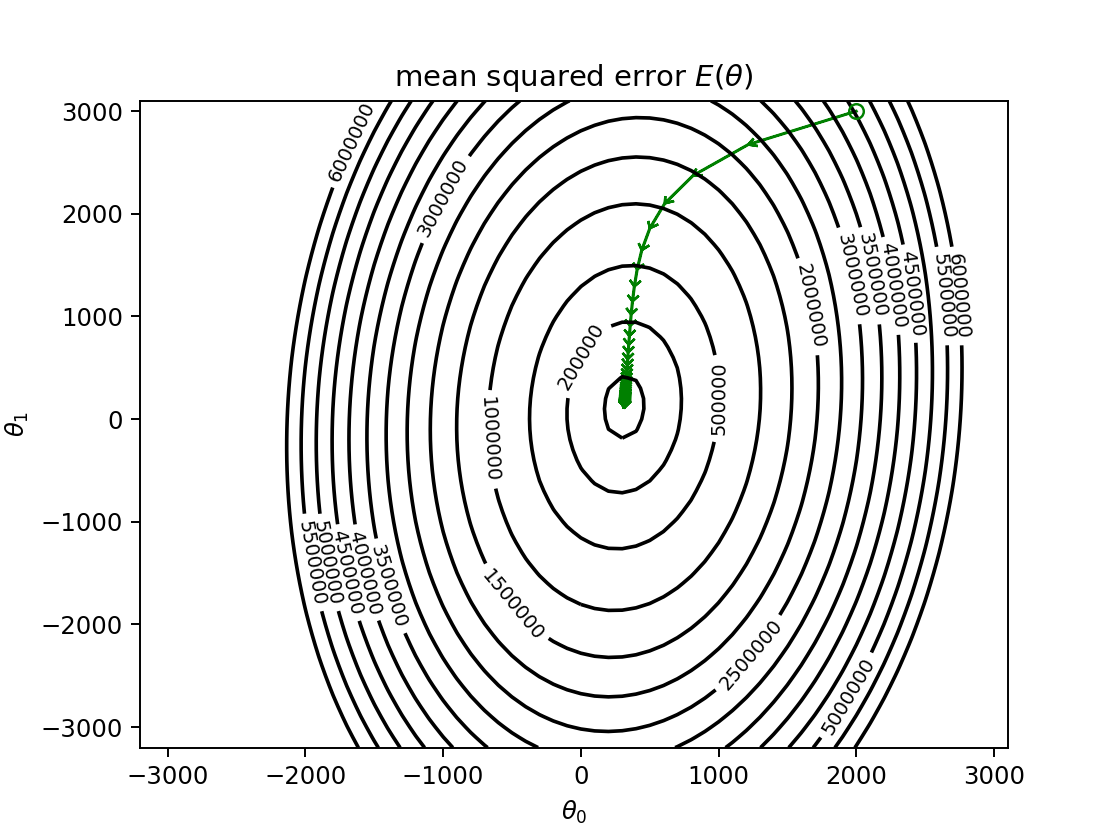

In [12]:
theta_init = np.array([2000., 3000.])
# a better starting value for theta would be [meancount, 0]

[Theta1, err1] = gradient_descent(theta_init, learning_rate = 0.25) 
print("theta after optimization: ", Theta1[:, -1])
plot_progress(Theta1, err1, col='green')

### An <span style="color:red">unsuccessful</span> run of gradient descent
If the learning rate is too high, a *local optimum* may not be found. 
If the learning rate is too small, learning can take a (prohibitively) long time.

error after  0  iterations:  4562314.689608637  gradient=  [3145.30364372 1307.64634278]
error after  10  iterations:  2580415.8635635036  gradient=  [3194.77610654 -163.01822746]
error after  20  iterations:  2792435.5855586044  gradient=  [3324.69614437 -171.30746779]
error after  30  iterations:  3022064.6597415633  gradient=  [3459.98824146 -178.2802981 ]
error after  40  iterations:  3270762.6205689493  gradient=  [3600.78588584 -185.5350779 ]
error after  50  iterations:  3540112.988935663  gradient=  [3747.31302281 -193.08507522]
error after  60  iterations:  3831830.7846824755  gradient=  [3899.8028031  -200.94230532]
error after  70  iterations:  4147773.4465447688  gradient=  [4058.49786513 -209.11927047]
error after  80  iterations:  4489952.658920528  gradient=  [4223.65072105 -217.62898167]
error after  90  iterations:  4860547.160758072  gradient=  [4395.52415851 -226.48497939]
error after  100  iterations:  5261916.618121245  gradient=  [4574.39165879 -235.70135511]
thet

<IPython.core.display.Javascript object>


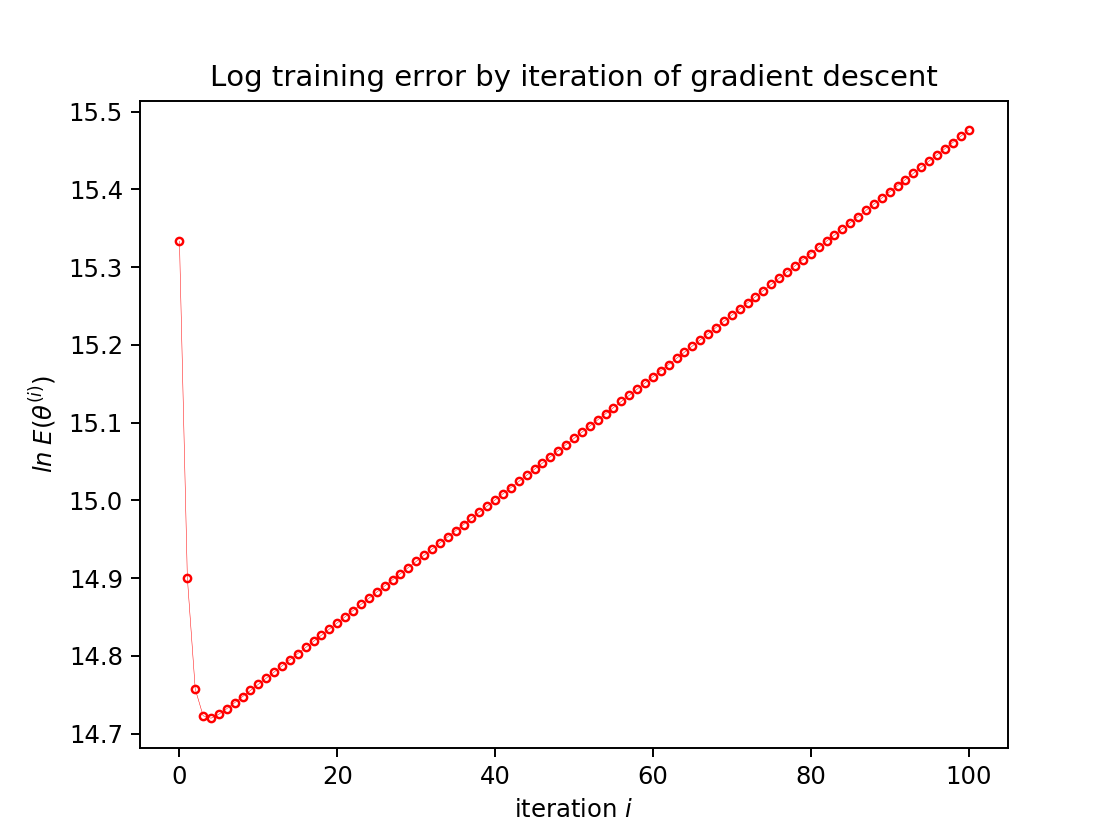

<IPython.core.display.Javascript object>


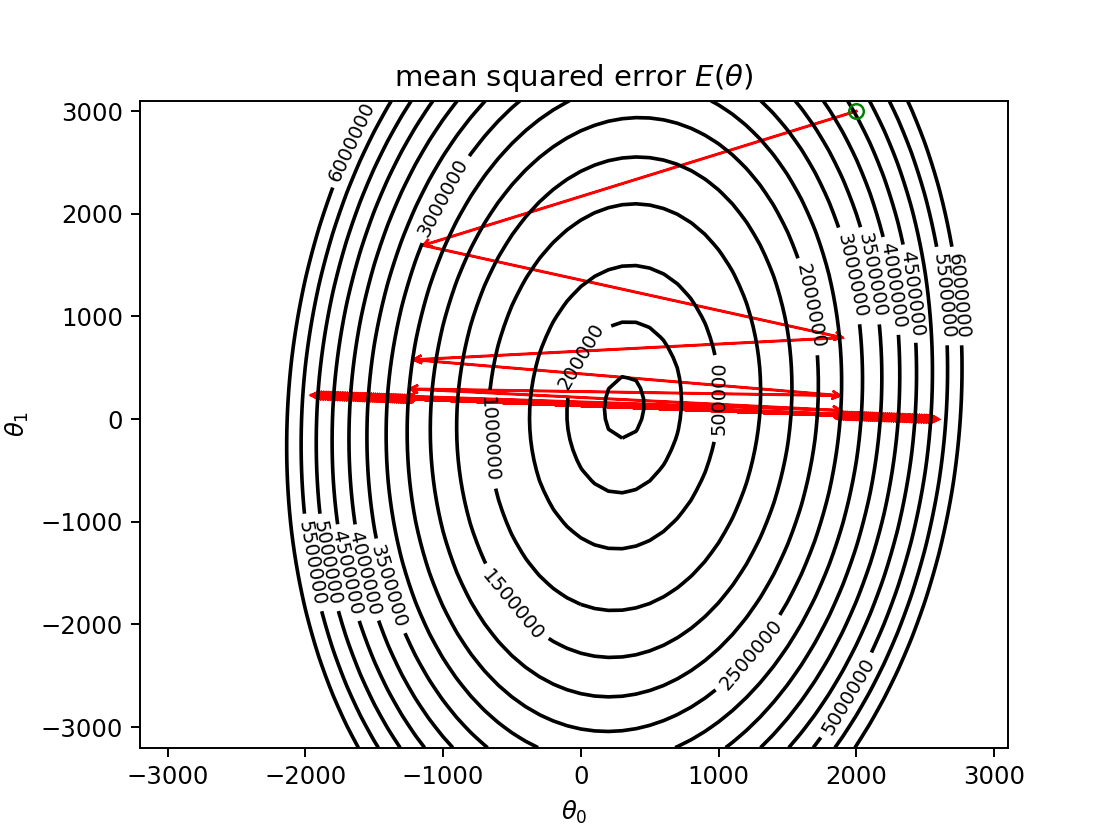

In [13]:
[Theta2, err2] = gradient_descent(theta_init, learning_rate = 1.0) # this learning rate is a little too high 
print("theta after optimization: ", Theta2[:, -1])
plot_progress(Theta2, err2, col='red')

## Solution 2: high-level
A high-level approach is recommended for most practical applications. For this, TensorFlow 2 uses a build-in Keras library with common ML functions and model components.

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate = .1, nesterov=False, momentum = 0.9)
# SGD: stochastic gradient descent
loss_object = tf.keras.losses.MeanSquaredError()
# This common and preimplemented loss implements the MSE function defined in equation (1).

In [15]:
np.random.seed(1) # make it reproducible
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# A tf.data.Dataset has commonly used functions for random sampling, obtaining subsets, transformations
# iterating over large numbers of images on disk (using TFRecord).

dataset = dataset.shuffle(m).batch(m) # random order, use whole dataset as 'batch' for comparability
# Normally, the batch size would be smaller, e.g. 32.

In [16]:
# Get a predefined linear model with one single output variable (unit) and one weight per input.
# Default is random initialization.
model = tf.keras.layers.Dense(units = 1,
                              use_bias = False, # bias equivalent to adding x_0 := 1
                              dtype = 'float64')

In [17]:
# one gradient descent step
def train_step(x, y):
    with tf.GradientTape() as tape:
        t = model(x) # predicted rental demand
        t = tf.reshape(t, [-1])
        E = loss_object(y, t)
    grads = tape.gradient(E, model.trainable_variables)
    # this makes a parameter update using the gradient
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return E

In [18]:
for epoch in range(100):
    # loop over batches of dataset
    # Here it is here just a single big batch for comparability with Solution 1.
    for batchnumber, (x, y) in enumerate(dataset):
        # x: batch features of shape (batch_size, 2)
        # y: batch labels
        E = train_step(x, y)

In [19]:
# final loss and prediction computed on all training data
pred = model(X_train)
pred = tf.reshape(pred, [m])
E = loss_object(y_train, pred)
print("final error = ", E.numpy())
print("theta:\n", model.trainable_variables[0].numpy())

final error =  27224.720703125
theta:
 [[316.45798273]
 [116.1688878 ]]


## Plot predictions

<IPython.core.display.Javascript object>


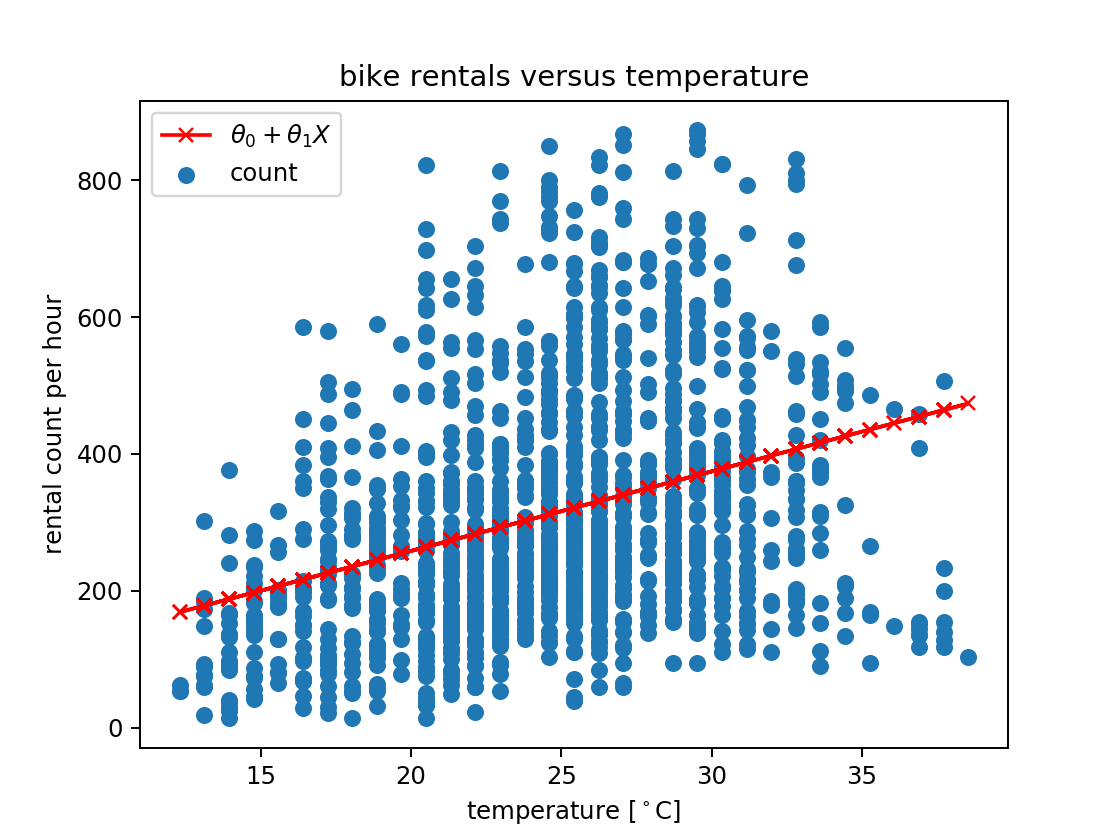

In [20]:
# draw the same scatterplot as above
ax = scatterplot_rentals()

# now add the predictions, here a regression line
ax.plot(temps, pred, 'rx-', label=r"$\theta_0 + \theta_1 X$") # - draws line connecting (r)ed crosses (x)
ax.legend(loc = 'upper left');